In [148]:
'''
!pip install pyyaml
!pip install matplotlib-venn
!pip install numpy
!pip install maya
'''
!pip install decorator==5.0.5

In [149]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
sns.set_style("whitegrid")
from pprint import pprint
import sqlite3
import yaml
import re
from datetime import datetime
import maya
from collections import Counter
from glob import glob
import ast
import json
from sklearn.preprocessing import StandardScaler

try: # for pip >= 10
    from pip._internal.req import parse_requirements
except ImportError: # for pip <= 9.0.3
    from pip.req import parse_requirements

from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

import networkx as nx
import networkx.algorithms.community as nxcom

import bokeh.io
from bokeh.io import output_file, show
from bokeh.resources import INLINE
from bokeh.models import (BoxSelectTool, Circle, EdgesAndLinkedNodes, HoverTool,
                          MultiLine, NodesAndLinkedEdges, Plot, Range1d, TapTool,
                         BoxZoomTool, ResetTool, OpenURL, CustomJS, Column, SaveTool)
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook
from bokeh.models.graphs import from_networkx
from bokeh.models import TextInput, Button

%matplotlib inline

# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")

## Easier navigation:

------------------------------------

### 1. <a href='#setup1'>Setup timing csv / real-user-sys</a>
### 2. <a href='#setup2'>Setup dependency/size csv</a>
### 3. <a href='#setup3'>Setup scrape csv</a>
### 4. <a href='#merge'>Merge CSVs</a>
------------------------------------
### 5. <a href='#tree'>Dependencies tree</a>
### 6. <a href='#dep2'>Iterated Dependencies tree</a>
### 7. <a href='#io'>Incoming/Outgoing dependency count</a>
### 8. <a href='#cent'>Centrality Measures</a>
------------------------------------
### 9. <a href='#s'>Individual size values</a>
### 10. <a href='#Heatmap'>Heatmap</a>
### 11. <a href='#choose'>Choosing columns</a>

<a name='setup1'></a>
## 1. Setup timing csv / real-user-sys


 - Time to install package
 
 
 Columns: ['library', 'real avg', 'real std', 'real max', 'count', 'sys avg','sys std', 'sys max', 'user avg', 'user std', 'user max']
<br>

In [150]:
categories = ["real", "user", "sys"]
chosen_category = categories[0]
t_df = pd.read_csv("combined_times_" + chosen_category + ".csv").drop([0, 1])
t_df = t_df.rename({chosen_category + "_time_solo_len": "count"}, axis=1)
t_df["library"] = t_df["library"].str.lower()
t_df = t_df.reset_index().drop("index", axis=1)
for col in t_df.columns:
    if col != "library":
        t_df[col] = t_df[col].astype(float)
        
# temporary solution
#t_df = t_df[~t_df.library.duplicated(keep='first')]
t_df

,library,count,real_time_solo_median,real_time_solo_average,real_time_solo_std,real_time_solo_max,real_time_full_median,real_time_full_average,real_time_full_std,real_time_full_max,real_time_constant_median,real_time_constant_average,real_time_constant_std,real_time_constant_max
0,ablog,4.0,1.1835,1.186500,0.022782,1.215,7.8170,7.823750,0.071765,7.916,0.9090,0.908250,0.055722,0.975
1,absl-py,4.0,0.9970,0.992500,0.027671,1.016,0.9825,0.984500,0.045684,1.042,0.7995,0.787000,0.039098,0.819
2,abtem,4.0,1.1500,1.197500,0.113468,1.365,14.4205,14.455500,0.490117,15.000,0.8705,0.848000,0.060437,0.890
3,abydos,4.0,1.3605,1.353000,0.052390,1.402,4.1120,4.102000,0.082349,4.176,0.7955,0.779750,0.036022,0.802
4,acstools,7.0,3.9760,4.022286,0.139978,4.186,9.6860,9.671571,0.166695,9.932,0.8350,0.849571,0.037116,0.908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5181,zope.interface,4.0,1.3775,1.397500,0.073993,1.495,1.3690,1.373250,0.018679,1.399,0.7450,0.741000,0.051929,0.799
5182,zope.lifecycleevent,7.0,0.9060,0.900571,0.048798,0.948,1.5890,1.585571,0.089539,1.691,0.8100,0.805143,0.032277,0.842
5183,zope.proxy,1.0,1.0590,1.059000,NaN,1.059,1.5390,1.539000,NaN,1.539,0.7950,0.795000,NaN,0.795
5184,zstandard,4.0,1.2005,1.214000,0.049806,1.280,1.2555,1.250750,0.029904,1.278,0.7880,0.778250,0.037748,0.810


<a name='setup2'></a>
## 2. Setup dependency/size csv

 - Package size
 - Package dependencies
 
  
 Columns: ['library', 'dependencies', 'size', 'size_full']
<br>

3 methods for string representation of list to list:
- Eval()
- ast_literal eval()
- strip 

In [151]:
ds_df = pd.read_csv("combined_depsize.csv").drop("Unnamed: 0", axis=1)

for i in np.arange(len(ds_df["dependencies"])):
    try:
        ds_df["dependencies"][i] = eval(ds_df["dependencies"][i])
        for j in np.arange(len(ds_df["dependencies"][i])):
            ds_df["dependencies"][i][j] = ds_df["dependencies"][i][j].lower().strip()
    except:
        pass
    
ds_df

,library,dependencies,size,size_full
0,cutecharts,[jinja2],1.296,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...
1,postgres,"[psycopg2-binary, psycopg2-pool]",0.144,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...
2,gpustat,"[six, nvidia-ml-py3, psutil, blessings]",1.864,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...
3,df2gspread,"[argparse, google-api-python-client, gspread, ...",82.632,47M /home/ubuntu/ve/randomenv/lib/python3.6/si...
4,pyprism,ERROR,88.836,62M /home/ubuntu/ve/randomenv/lib/python3.6/si...
...,...,...,...,...
5183,pyats.aetest,"[pyats.results, pyats.aereport, jinja2, pyats....",66.252,39M /home/ubuntu/ve/randomenv/lib/python3.6/si...
5184,dicrivers,[],0.040,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...
5185,airr,"[pandas, pyyaml, yamlordereddictloader, setupt...",75.040,47M /home/ubuntu/ve/randomenv/lib/python3.6/si...
5186,python-afl,ERROR,0.000,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...


In [152]:
len(ds_df[ds_df["dependencies"] == "ERROR"])

611

In [153]:
len(ds_df[ds_df["size"] == 0])

1107

<a name='setup3'></a>
## 3. Setup scrape csv

 
 - Package stats
 - Package versions
 
 Columns: ['library', 'Contributors', 'Dependencies', 'Dependent packages', 'Dependent repositories', 'First release', 'Forks', 'Latest release', 'Open Issues/PRs', 'Repository size', 'SourceRank', 'Stars', 'Total releases', 'Version Number', 'Version Time', 'Watchers']
<br>

In [154]:
with open('scraper_final.txt') as f:
    reloaded_example = json.load(f)

In [155]:
s_df = pd.read_json(reloaded_example)
s_df

,library,Contributors,Dependencies,Dependent packages,Dependent repositories,First release,Forks,Latest release,Open Issues/PRs,Repository size,SourceRank,Stars,Total releases,Version Number,Version Time,Watchers
0,cutecharts,2.0,1.0,0.0,0.0,"Oct 12, 2019",56.0,"Oct 14, 2019",2.0,81.10,11.0,503.0,3.0,"[1.2.0, 1.1.0, 1.0.0]","[1571038080000, 1571034300000, 1570870740000]",18.0
1,postgres,6.0,2.0,2.0,192.0,"Aug 8, 2013",17.0,"Oct 19, 2019",16.0,239.00,12.0,55.0,12.0,"[3.0.0, 2.2.2, 2.2.1, 2.2.0, 2.1.2, 2.1.1, 2.1...","[1571513400000, 1536735600000, 1444434720000, ...",8.0
2,gpustat,10.0,0.0,68.0,29.0,"Aug 19, 2016",202.0,"Jan 2, 2021",23.0,271.00,16.0,2479.0,11.0,"[1.0.0b1, 0.6.0, 0.5.0, 0.4.1, 0.4.0, 0.3.2, 0...","[1609567140000, 1563776220000, 1536551400000, ...",39.0
3,df2gspread,6.0,0.0,2.0,3.0,"Jan 19, 2016",26.0,"Jan 3, 2019",12.0,116.00,10.0,117.0,21.0,"[1.0.4, 1.0.3, 1.0.2, 1.0.1, 1.0.0, 0.2.5, 0.0...","[1546516500000, 1525855980000, 1525337280000, ...",8.0
4,pyprism,2.0,0.0,0.0,1.0,"Apr 4, 2018",14.0,"Jul 1, 2020",11.0,25.20,9.0,23.0,5.0,"[1.0.4, 1.0.3, 1.0.2, 1.0.1, 1.0.0]","[1593632700000, 1522935600000, 1522892040000, ...",6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5185,dwave-ocean-sdk,13.0,18.0,3.0,20.0,"May 11, 2018",101.0,"Jan 25, 2021",14.0,8.62,12.0,268.0,29.0,"[3.3.0, 3.2.0, 3.1.1, 3.1.0, 3.0.1, 3.0.0, 3.0...","[1611534180000, 1608150060000, 1602127440000, ...",32.0
5186,mpi4py,0.0,0.0,120.0,376.0,"Oct 15, 2006",20.0,"Nov 4, 2019",NaN,10.80,15.0,NaN,13.0,"[3.0.3, 3.0.2, 3.0.1, 3.0.0, 2.0.0, 1.3.1, 0.6...","[1572872700000, 1560254940000, 1550239440000, ...",48.0
5187,simple_colors,1.0,0.0,1.0,1.0,"Nov 23, 2018",0.0,"Jan 14, 2019",1.0,4.88,6.0,2.0,6.0,"[0.1.5, 0.1.4, 0.1.3, 0.1.2, 0.1.1, 0.1.0]","[1547456940000, 1547358360000, 1547357880000, ...",1.0
5188,altair-viewer,2.0,2.0,4.0,0.0,"Dec 29, 2019",4.0,"Mar 31, 2020",1.0,2.26,11.0,46.0,6.0,"[0.3.0, 0.2.1, 0.2.0, 0.1.2, 0.1.1, 0.1.0]","[1585658640000, 1583295120000, 1579097280000, ...",3.0


<a name='merge'></a>
## 4. Merge CSVs

<br>

In [156]:
merge_df = ds_df.merge(s_df, on="library").merge(t_df, on="library")

In [157]:
df = merge_df.drop(merge_df[merge_df["dependencies"] == "ERROR"].index)

In [158]:
df

,library,dependencies,size,size_full,Contributors,Dependencies,Dependent packages,Dependent repositories,First release,Forks,...,real_time_solo_std,real_time_solo_max,real_time_full_median,real_time_full_average,real_time_full_std,real_time_full_max,real_time_constant_median,real_time_constant_average,real_time_constant_std,real_time_constant_max
0,cutecharts,[jinja2],1.296,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,2.0,1.0,0.0,0.0,"Oct 12, 2019",56.0,...,NaN,0.901,1.298,1.298000,NaN,1.298,0.757,0.757000,NaN,0.757
1,postgres,"[psycopg2-binary, psycopg2-pool]",0.144,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,6.0,2.0,2.0,192.0,"Aug 8, 2013",17.0,...,NaN,0.915,1.371,1.371000,NaN,1.371,0.760,0.760000,NaN,0.760
2,gpustat,"[six, nvidia-ml-py3, psutil, blessings]",1.864,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,10.0,0.0,68.0,29.0,"Aug 19, 2016",202.0,...,NaN,2.445,3.956,3.956000,NaN,3.956,0.743,0.743000,NaN,0.743
3,df2gspread,"[argparse, google-api-python-client, gspread, ...",82.632,47M /home/ubuntu/ve/randomenv/lib/python3.6/si...,6.0,0.0,2.0,3.0,"Jan 19, 2016",26.0,...,NaN,1.893,10.030,10.030000,NaN,10.030,1.105,1.105000,NaN,1.105
5,ddeint,"[numpy, scipy]",87.040,62M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,0.0,0.0,0.0,"May 4, 2014",NaN,...,NaN,1.547,6.858,6.858000,NaN,6.858,0.790,0.790000,NaN,0.790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5180,hep-ml,"[theano, numpy, pandas, six, scipy, scikit-learn]",157.900,62M /home/ubuntu/ve/randomenv/lib/python3.6/si...,8.0,6.0,0.0,0.0,"Jul 27, 2015",48.0,...,0.068665,1.183,14.760,14.717714,0.279517,14.994,0.850,0.845143,0.046792,0.906
5181,pyats.aetest,"[pyats.results, pyats.aereport, jinja2, pyats....",66.252,39M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,9.0,3.0,2.0,"Nov 27, 2017",NaN,...,0.111764,1.705,13.885,13.804857,0.318377,14.229,1.061,1.065429,0.030446,1.099
5182,dicrivers,[],0.040,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,1.0,0.0,0.0,0.0,"Jun 6, 2019",0.0,...,0.018752,0.906,0.902,0.894714,0.040376,0.966,0.759,0.745429,0.043177,0.784
5183,airr,"[pandas, pyyaml, yamlordereddictloader, setupt...",75.040,47M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,0.0,4.0,1.0,"May 3, 2018",NaN,...,0.081940,1.789,8.319,8.266000,0.175492,8.489,0.793,0.796143,0.032936,0.846


<a name='tree'></a>
## 5. Dependencies tree

<br>

In [159]:
edge_list = pd.DataFrame(columns= ['Library', 'Dependency', 'Weight'])

counter = 0
a = datetime.now()
for index, row in df.iterrows():
    source = row["library"]
    for d in row["dependencies"]:
        edge_list = edge_list.append({'Library': source, 'Dependency': d, 'Weight': 1}, ignore_index=True)
    counter += 1
    if counter % 1000 == 0:
        b = datetime.now()
        print(str(counter) + ": " + str((b - a).seconds))
        a = datetime.now()
            
edge_list

1000: 5
2000: 5
3000: 5
4000: 6


,Library,Dependency,Weight
0,cutecharts,jinja2,1
1,postgres,psycopg2-binary,1
2,postgres,psycopg2-pool,1
3,gpustat,six,1
4,gpustat,nvidia-ml-py3,1
...,...,...,...
14598,census_area,shapely,1
14599,census_area,census,1
14600,census_area,pyshp,1
14601,census_area,pyproj,1


In [160]:
D = nx.convert_matrix.from_pandas_edgelist(edge_list,'Library','Dependency',['Weight'],nx.DiGraph)

In [161]:
nx.info(D)

'Name: \nType: DiGraph\nNumber of nodes: 4639\nNumber of edges: 14592\nAverage in degree:   3.1455\nAverage out degree:   3.1455'

In [162]:
[n for n in D.neighbors("pandas")]

['python-dateutil', 'numpy', 'pytz']

Check if any cycles exist in the directed graph.

In [163]:
for cycle in nx.simple_cycles(D):
    print(cycle)

['naked']
['jupyter-nbutils', 'jupyter-require']
['mkdocs-material-extensions', 'mkdocs-material']
['pyats.topology', 'pyats.utils']


Bottom cells only works if cycles = 0 -> need some workaround

#### Finds all dependencies for a package

In [164]:
def find_neighbors(col):
    return helper_neighbors(col, [])

def helper_neighbors(col, orig):
    n_list = []
    orig.append(col)
    for n in D.neighbors(col):
        if n not in orig:
            n_dep = helper_neighbors(n, orig)
            if len(n_dep) != 0:
                for no in n_dep:
                    n_list.append(no)
            n_list.append(n)
    return list(set([i.split('=', 1)[0].split('<')[0].split('>')[0].split('[')[0].split('~')[0].
                     split(';')[0].strip().lower() for i in n_list]))
        

Sanity checking by showing layers:

In [165]:
def find_neighbors_sanity(col):
    n_list = []
    for n in D.neighbors(col):
        n_dep = find_neighbors(n)
        if len(n_dep) != 0:
            n_list.append(n_dep)
        n_list.append(n)
    return n_list
        

In [166]:
find_neighbors("jupyter-require")

['ptyprocess',
 'pycparser',
 'pyrsistent',
 'lxml',
 'nest-asyncio',
 'jedi',
 'jupyter-latex-envs',
 'daiquiri',
 'prompt-toolkit',
 'jupyter-contrib-nbextensions',
 'ipykernel',
 'defusedxml',
 'zipp',
 'jsonschema',
 'jupyterlab-pygments',
 'mistune',
 'notebook',
 'argon2-cffi',
 'webencodings',
 'jupyter-core',
 'terminado',
 'pexpect',
 'jupyter-contrib-core',
 'jupyter-highlight-selected-word',
 'importlib-metadata',
 'ipython-genutils',
 'testpath',
 'tornado',
 'pyzmq',
 'prometheus-client',
 'nbclient',
 'nbformat',
 'traitlets',
 'jinja2',
 'setuptools',
 'ipython',
 'async-generator',
 'six',
 'jupyter-nbextensions-configurator',
 'parso',
 'typing-extensions',
 'packaging',
 'jupyter-nbutils',
 'markupsafe',
 'pickleshare',
 'decorator',
 'backcall',
 'pyparsing',
 'jupyter-client',
 'pandocfilters',
 'pyyaml',
 'python-dateutil',
 'cffi',
 'attrs',
 'wcwidth',
 'nbconvert',
 'python-json-logger',
 'pygments',
 'bleach',
 'send2trash',
 'entrypoints',
 'csscompressor']

In [167]:
find_neighbors_sanity("spyder")

['psutil',
 'pyxdg',
 'qtpy',
 'parso',
 'diff-match-patch',
 'setuptools',
 ['pyqt5', 'pyqt5-qt5', 'pyqtwebengine-qt5', 'pyqt5-sip'],
 'pyqtwebengine',
 ['ptyprocess',
  'jedi',
  'prompt-toolkit',
  'ipykernel',
  'jupyter-core',
  'pexpect',
  'ipython-genutils',
  'tornado',
  'pyzmq',
  'traitlets',
  'cloudpickle',
  'setuptools',
  'ipython',
  'six',
  'parso',
  'pickleshare',
  'decorator',
  'backcall',
  'jupyter-client',
  'wurlitzer',
  'python-dateutil',
  'wcwidth',
  'pygments'],
 'spyder-kernels',
 'three-merge',
 ['sphinxcontrib-applehelp',
  'idna',
  'babel',
  'certifi',
  'sphinxcontrib-qthelp',
  'chardet',
  'snowballstemmer',
  'alabaster',
  'sphinxcontrib-devhelp',
  'jinja2',
  'setuptools',
  'sphinxcontrib-htmlhelp',
  'packaging',
  'markupsafe',
  'urllib3',
  'pyparsing',
  'docutils',
  'pytz',
  'imagesize',
  'pygments',
  'requests',
  'sphinxcontrib-serializinghtml',
  'sphinxcontrib-jsmath'],
 'sphinx',
 'pickleshare',
 'atomicwrites',
 ['setupto

<a name='dep2'></a>
## 6. Iterated Dependencies Tree

<br>

In [168]:
df = df.set_index("library")

In [169]:
df["dependencies full"] = None

In [170]:
len(D.nodes)

4639

In [171]:
edge_list = pd.DataFrame(columns= ['Library', 'Dependency', 'Weight'])

counter = 0
a = datetime.now()
for node in D.nodes:
    source = node
    d_full = []
    for d in find_neighbors(node):
        edge_list = edge_list.append({'Library': source, 'Dependency': d, 'Weight': 1}, ignore_index=True)
        d_full.append(d)
    df["dependencies full"][source] = d_full
    counter += 1
    if counter % 1000 == 0:
        b = datetime.now()
        print(str(counter) + ": " + str((b - a).seconds))
        a = datetime.now()
            
edge_list

1000: 17
2000: 28
3000: 30
4000: 37


,Library,Dependency,Weight
0,cutecharts,markupsafe,1
1,cutecharts,jinja2,1
2,jinja2,markupsafe,1
3,postgres,psycopg2-pool,1
4,postgres,psycopg2-binary,1
...,...,...,...
56326,census_area,pyproj,1
56327,census_area,requests,1
56328,census_area,census,1
56329,census_area,shapely,1


In [172]:
for i in range(len(df)):
    if df["dependencies full"][i] == None:
        df["dependencies full"][i] = []

In [173]:
df = df.reset_index()

In [174]:
iD = nx.convert_matrix.from_pandas_edgelist(edge_list,'Library','Dependency',['Weight'],nx.DiGraph)

In [175]:
nx.info(iD)

'Name: \nType: DiGraph\nNumber of nodes: 4639\nNumber of edges: 56331\nAverage in degree:  12.1429\nAverage out degree:  12.1429'

In [176]:
[n for n in iD.neighbors("pandas")]

['python-dateutil', 'numpy', 'six', 'pytz']

<a name='io'></a>
## 7. Incoming/Outgoing dependency count

<br>

In [177]:
print('IN/OUT AVG:', np.mean([iD.in_degree(n) for n in iD.nodes]))

IN/OUT AVG: 12.14291873248545


In [178]:
in_d, out_d = [], []
for p in df["library"]:
    either_d = type(iD.out_degree(p))
    if either_d == int:
        in_d.append(iD.in_degree(p))
        out_d.append(iD.out_degree(p))
    else:
        in_d.append(0)
        out_d.append(0)
df["Incoming Dep"] = in_d
df["Outgoing Dep"] = out_d

In [179]:
df

,library,dependencies,size,size_full,Contributors,Dependencies,Dependent packages,Dependent repositories,First release,Forks,...,real_time_full_average,real_time_full_std,real_time_full_max,real_time_constant_median,real_time_constant_average,real_time_constant_std,real_time_constant_max,dependencies full,Incoming Dep,Outgoing Dep
0,cutecharts,[jinja2],1.296,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,2.0,1.0,0.0,0.0,"Oct 12, 2019",56.0,...,1.298000,NaN,1.298,0.757,0.757000,NaN,0.757,"[markupsafe, jinja2]",0,2
1,postgres,"[psycopg2-binary, psycopg2-pool]",0.144,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,6.0,2.0,2.0,192.0,"Aug 8, 2013",17.0,...,1.371000,NaN,1.371,0.760,0.760000,NaN,0.760,"[psycopg2-pool, psycopg2-binary]",0,2
2,gpustat,"[six, nvidia-ml-py3, psutil, blessings]",1.864,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,10.0,0.0,68.0,29.0,"Aug 19, 2016",202.0,...,3.956000,NaN,3.956,0.743,0.743000,NaN,0.743,"[psutil, blessings, six, nvidia-ml-py3]",1,4
3,df2gspread,"[argparse, google-api-python-client, gspread, ...",82.632,47M /home/ubuntu/ve/randomenv/lib/python3.6/si...,6.0,0.0,2.0,3.0,"Jan 19, 2016",26.0,...,10.030000,NaN,10.030,1.105,1.105000,NaN,1.105,"[idna, google-api-core, certifi, google-api-py...",0,31
4,ddeint,"[numpy, scipy]",87.040,62M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,0.0,0.0,0.0,"May 4, 2014",NaN,...,6.858000,NaN,6.858,0.790,0.790000,NaN,0.790,"[scipy, numpy]",0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4570,hep-ml,"[theano, numpy, pandas, six, scipy, scikit-learn]",157.900,62M /home/ubuntu/ve/randomenv/lib/python3.6/si...,8.0,6.0,0.0,0.0,"Jul 27, 2015",48.0,...,14.717714,0.279517,14.994,0.850,0.845143,0.046792,0.906,"[pytz, pandas, six, python-dateutil, threadpoo...",0,10
4571,pyats.aetest,"[pyats.results, pyats.aereport, jinja2, pyats....",66.252,39M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,9.0,3.0,2.0,"Nov 27, 2017",NaN,...,13.804857,0.318377,14.229,1.061,1.065429,0.030446,1.099,"[idna, dill, multidict, pycparser, psutil, asy...",7,37
4572,dicrivers,[],0.040,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,1.0,0.0,0.0,0.0,"Jun 6, 2019",0.0,...,0.894714,0.040376,0.966,0.759,0.745429,0.043177,0.784,[],0,0
4573,airr,"[pandas, pyyaml, yamlordereddictloader, setupt...",75.040,47M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,0.0,4.0,1.0,"May 3, 2018",NaN,...,8.266000,0.175492,8.489,0.793,0.796143,0.032936,0.846,"[yamlordereddictloader, pyyaml, setuptools, py...",0,8


<a name='cent'></a>
## 8. Centrality Measures

<br>

In [180]:
degree_centrality = nx.degree_centrality(iD)
closeness_centrality = nx.closeness_centrality(iD)
#betweenness_centrality = nx.betweenness_centrality(iD)
hub, authority = nx.hits(iD, max_iter=600)
katz_centrality = nx.katz_centrality(iD)

Authority is what we want, aka. the number of edges pointing to a node. Hub is outgoing

In [181]:
centrality_dict = [degree_centrality, closeness_centrality, katz_centrality, hub, authority]
cent = pd.DataFrame(centrality_dict).T.reset_index()
cent.columns = ["library","Degree","Closeness","Katz", "Hub", "Authority"]
cent.sort_values("Authority", ascending=False).head(20)

,library,Degree,Closeness,Katz,Hub,Authority
9,six,0.426908,0.426908,0.422610,0.000000,0.022448
34,python-dateutil,0.274687,0.274472,0.221720,0.000049,0.018502
46,typing-extensions,0.258085,0.258085,0.240060,0.000000,0.017647
148,zipp,0.219491,0.219491,0.208197,0.000000,0.016653
114,importlib-metadata,0.214532,0.214101,0.184415,0.000075,0.016530
30,pyparsing,0.218413,0.218413,0.176182,0.000000,0.016184
25,setuptools,0.200733,0.200733,0.176207,0.000000,0.016031
22,numpy,0.341311,0.341311,0.258190,0.000000,0.014174
12,idna,0.236740,0.236740,0.192186,0.000000,0.013532
14,certifi,0.235231,0.235231,0.187085,0.000000,0.013528


In [182]:
df

,library,dependencies,size,size_full,Contributors,Dependencies,Dependent packages,Dependent repositories,First release,Forks,...,real_time_full_average,real_time_full_std,real_time_full_max,real_time_constant_median,real_time_constant_average,real_time_constant_std,real_time_constant_max,dependencies full,Incoming Dep,Outgoing Dep
0,cutecharts,[jinja2],1.296,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,2.0,1.0,0.0,0.0,"Oct 12, 2019",56.0,...,1.298000,NaN,1.298,0.757,0.757000,NaN,0.757,"[markupsafe, jinja2]",0,2
1,postgres,"[psycopg2-binary, psycopg2-pool]",0.144,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,6.0,2.0,2.0,192.0,"Aug 8, 2013",17.0,...,1.371000,NaN,1.371,0.760,0.760000,NaN,0.760,"[psycopg2-pool, psycopg2-binary]",0,2
2,gpustat,"[six, nvidia-ml-py3, psutil, blessings]",1.864,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,10.0,0.0,68.0,29.0,"Aug 19, 2016",202.0,...,3.956000,NaN,3.956,0.743,0.743000,NaN,0.743,"[psutil, blessings, six, nvidia-ml-py3]",1,4
3,df2gspread,"[argparse, google-api-python-client, gspread, ...",82.632,47M /home/ubuntu/ve/randomenv/lib/python3.6/si...,6.0,0.0,2.0,3.0,"Jan 19, 2016",26.0,...,10.030000,NaN,10.030,1.105,1.105000,NaN,1.105,"[idna, google-api-core, certifi, google-api-py...",0,31
4,ddeint,"[numpy, scipy]",87.040,62M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,0.0,0.0,0.0,"May 4, 2014",NaN,...,6.858000,NaN,6.858,0.790,0.790000,NaN,0.790,"[scipy, numpy]",0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4570,hep-ml,"[theano, numpy, pandas, six, scipy, scikit-learn]",157.900,62M /home/ubuntu/ve/randomenv/lib/python3.6/si...,8.0,6.0,0.0,0.0,"Jul 27, 2015",48.0,...,14.717714,0.279517,14.994,0.850,0.845143,0.046792,0.906,"[pytz, pandas, six, python-dateutil, threadpoo...",0,10
4571,pyats.aetest,"[pyats.results, pyats.aereport, jinja2, pyats....",66.252,39M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,9.0,3.0,2.0,"Nov 27, 2017",NaN,...,13.804857,0.318377,14.229,1.061,1.065429,0.030446,1.099,"[idna, dill, multidict, pycparser, psutil, asy...",7,37
4572,dicrivers,[],0.040,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,1.0,0.0,0.0,0.0,"Jun 6, 2019",0.0,...,0.894714,0.040376,0.966,0.759,0.745429,0.043177,0.784,[],0,0
4573,airr,"[pandas, pyyaml, yamlordereddictloader, setupt...",75.040,47M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,0.0,4.0,1.0,"May 3, 2018",NaN,...,8.266000,0.175492,8.489,0.793,0.796143,0.032936,0.846,"[yamlordereddictloader, pyyaml, setuptools, py...",0,8


In [183]:
q = cent.columns
q

Index(['library', 'Degree', 'Closeness', 'Katz', 'Hub', 'Authority'], dtype='object')

In [184]:
q_df = df.merge(cent, on="library", how="left")

In [185]:
q_df[q] = q_df[q].fillna(0)

In [186]:
q_df

,library,dependencies,size,size_full,Contributors,Dependencies,Dependent packages,Dependent repositories,First release,Forks,...,real_time_constant_std,real_time_constant_max,dependencies full,Incoming Dep,Outgoing Dep,Degree,Closeness,Katz,Hub,Authority
0,cutecharts,[jinja2],1.296,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,2.0,1.0,0.0,0.0,"Oct 12, 2019",56.0,...,NaN,0.757,"[markupsafe, jinja2]",0,2,0.000431,0.000000,0.001247,5.520817e-05,0.000000
1,postgres,"[psycopg2-binary, psycopg2-pool]",0.144,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,6.0,2.0,2.0,192.0,"Aug 8, 2013",17.0,...,NaN,0.760,"[psycopg2-pool, psycopg2-binary]",0,2,0.000431,0.000000,0.001247,2.200372e-07,0.000000
2,gpustat,"[six, nvidia-ml-py3, psutil, blessings]",1.864,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,10.0,0.0,68.0,29.0,"Aug 19, 2016",202.0,...,NaN,0.743,"[psutil, blessings, six, nvidia-ml-py3]",1,4,0.001078,0.000216,0.001371,5.212748e-05,0.000017
3,df2gspread,"[argparse, google-api-python-client, gspread, ...",82.632,47M /home/ubuntu/ve/randomenv/lib/python3.6/si...,6.0,0.0,2.0,3.0,"Jan 19, 2016",26.0,...,NaN,1.105,"[idna, google-api-core, certifi, google-api-py...",0,31,0.006684,0.000000,0.001247,4.506566e-04,0.000000
4,ddeint,"[numpy, scipy]",87.040,62M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,0.0,0.0,0.0,"May 4, 2014",NaN,...,NaN,0.790,"[scipy, numpy]",0,2,0.000431,0.000000,0.001247,4.705552e-05,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4570,hep-ml,"[theano, numpy, pandas, six, scipy, scikit-learn]",157.900,62M /home/ubuntu/ve/randomenv/lib/python3.6/si...,8.0,6.0,0.0,0.0,"Jul 27, 2015",48.0,...,0.046792,0.906,"[pytz, pandas, six, python-dateutil, threadpoo...",0,10,0.002156,0.000000,0.001247,2.006724e-04,0.000000
4571,pyats.aetest,"[pyats.results, pyats.aereport, jinja2, pyats....",66.252,39M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,9.0,3.0,2.0,"Nov 27, 2017",NaN,...,0.030446,1.099,"[idna, dill, multidict, pycparser, psutil, asy...",7,37,0.009487,0.001509,0.002282,3.099128e-04,0.000074
4572,dicrivers,[],0.040,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,1.0,0.0,0.0,0.0,"Jun 6, 2019",0.0,...,0.043177,0.784,[],0,0,0.000000,0.000000,0.000000,0.000000e+00,0.000000
4573,airr,"[pandas, pyyaml, yamlordereddictloader, setupt...",75.040,47M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,0.0,4.0,1.0,"May 3, 2018",NaN,...,0.032936,0.846,"[yamlordereddictloader, pyyaml, setuptools, py...",0,8,0.001725,0.000000,0.001247,2.091027e-04,0.000000


In [187]:
q_df = q_df.rename({"size":"total size"}, axis=1)

<a name='s'></a>
## 9. Individual size values

<br>

In [188]:
pack_q = q_df.to_json()
with open("tempalg.txt",'w') as f:
    json.dump(pack_q, f)

In [189]:
with open('tempalg.txt') as f:
    reloaded_example = json.load(f)
ag_df = pd.read_json(reloaded_example)

In [190]:
ag_df["size"] = ag_df["total size"]

In [191]:
ag_df["dependencies drained"] = ag_df["dependencies full"]
dep_full = ag_df["dependencies full"]
with open("depalg.pickle",'wb') as f:
    pickle.dump(dep_full, f)   

In [192]:
open_index = ag_df.index
counter = 1
while True:
    zero_index_size = {}
    zero_list = []
    for i in open_index:
        if len(ag_df.at[i, "dependencies drained"]) == 0:
            zero_index_size[ag_df.at[i, "library"]] = ag_df.at[i, "size"]
            zero_list.append(i)
    for i in open_index:
        for seen in zero_index_size:
            if seen in ag_df.at[i, "dependencies drained"]:
                ag_df.at[i, "dependencies drained"].remove(seen)
                ag_df.at[i, "size"] =  ag_df.at[i, "size"] - zero_index_size[seen]

    open_index = [ele for ele in open_index if ele not in zero_list]
    
    print(str(counter) + ": " + str(len(zero_list)))
    counter += 1
    
    if zero_list == []:
        break
        

1: 1176
2: 561
3: 583
4: 749
5: 421
6: 133
7: 80
8: 62
9: 33
10: 72
11: 34
12: 4
13: 2
14: 0


In [193]:
with open('depalg.pickle', 'rb') as f:
    dep_full = pickle.load(f)

In [194]:
ag_df["dependencies full"] = dep_full
ag_df["dependencies drained count"] = ag_df["dependencies drained"].apply(lambda x: len(x))

In [195]:
'''
while True:
    finished = {}
    for i in range(len(it_dependencies)):
        if len(it_dependencies[i]) == 1:
            # flawed line
            finished[it_dependencies[i][0]] = it_sizes[i]

    for i in range(len(it_dependencies)):
        for j in finished:
            if (j in it_dependencies[i]):
                it_dependencies[i].remove(j)
                it_sizes[i] -= finished[j]
    if finished == {}:
        break
        
'''      

'\nwhile True:\n    finished = {}\n    for i in range(len(it_dependencies)):\n        if len(it_dependencies[i]) == 1:\n            # flawed line\n            finished[it_dependencies[i][0]] = it_sizes[i]\n\n    for i in range(len(it_dependencies)):\n        for j in finished:\n            if (j in it_dependencies[i]):\n                it_dependencies[i].remove(j)\n                it_sizes[i] -= finished[j]\n    if finished == {}:\n        break\n        \n'

In [196]:
ag_df

,library,dependencies,total size,size_full,Contributors,Dependencies,Dependent packages,Dependent repositories,First release,Forks,...,Incoming Dep,Outgoing Dep,Degree,Closeness,Katz,Hub,Authority,size,dependencies drained,dependencies drained count
0,cutecharts,[jinja2],1.296,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,2.0,1.0,0.0,0.0,"Oct 12, 2019",56.0,...,0,2,0.000431,0.000000,0.001247,5.520820e-05,0.000000,1.880000e-01,[],0
1,postgres,"[psycopg2-binary, psycopg2-pool]",0.144,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,6.0,2.0,2.0,192.0,"Aug 8, 2013",17.0,...,0,2,0.000431,0.000000,0.001247,2.200000e-07,0.000000,1.440000e-01,[],0
2,gpustat,"[six, nvidia-ml-py3, psutil, blessings]",1.864,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,10.0,0.0,68.0,29.0,"Aug 19, 2016",202.0,...,1,4,0.001078,0.000216,0.001371,5.212750e-05,0.000017,8.800000e-02,[],0
3,df2gspread,"[argparse, google-api-python-client, gspread, ...",82.632,47M /home/ubuntu/ve/randomenv/lib/python3.6/si...,6.0,0.0,2.0,3.0,"Jan 19, 2016",26.0,...,0,31,0.006684,0.000000,0.001247,4.506566e-04,0.000000,-1.680000e-01,[],0
4,ddeint,"[numpy, scipy]",87.040,62M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,0.0,0.0,0.0,"May 4, 2014",NaN,...,0,2,0.000431,0.000000,0.001247,4.705550e-05,0.000000,4.000000e-02,[],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4570,hep-ml,"[theano, numpy, pandas, six, scipy, scikit-learn]",157.900,62M /home/ubuntu/ve/randomenv/lib/python3.6/si...,8.0,6.0,0.0,0.0,"Jul 27, 2015",48.0,...,0,10,0.002156,0.000000,0.001247,2.006724e-04,0.000000,7.105427e-15,[],0
4571,pyats.aetest,"[pyats.results, pyats.aereport, jinja2, pyats....",66.252,39M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,9.0,3.0,2.0,"Nov 27, 2017",NaN,...,7,37,0.009487,0.001509,0.002282,3.099128e-04,0.000074,3.951200e+01,"[async-lru, unicon.plugins, yamllint, pyats.co...",13
4572,dicrivers,[],0.040,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,1.0,0.0,0.0,0.0,"Jun 6, 2019",0.0,...,0,0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,4.000000e-02,[],0
4573,airr,"[pandas, pyyaml, yamlordereddictloader, setupt...",75.040,47M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,0.0,4.0,1.0,"May 3, 2018",NaN,...,0,8,0.001725,0.000000,0.001247,2.091027e-04,0.000000,2.400000e-01,[],0


In [197]:
q_df = ag_df
q_df

,library,dependencies,total size,size_full,Contributors,Dependencies,Dependent packages,Dependent repositories,First release,Forks,...,Incoming Dep,Outgoing Dep,Degree,Closeness,Katz,Hub,Authority,size,dependencies drained,dependencies drained count
0,cutecharts,[jinja2],1.296,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,2.0,1.0,0.0,0.0,"Oct 12, 2019",56.0,...,0,2,0.000431,0.000000,0.001247,5.520820e-05,0.000000,1.880000e-01,[],0
1,postgres,"[psycopg2-binary, psycopg2-pool]",0.144,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,6.0,2.0,2.0,192.0,"Aug 8, 2013",17.0,...,0,2,0.000431,0.000000,0.001247,2.200000e-07,0.000000,1.440000e-01,[],0
2,gpustat,"[six, nvidia-ml-py3, psutil, blessings]",1.864,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,10.0,0.0,68.0,29.0,"Aug 19, 2016",202.0,...,1,4,0.001078,0.000216,0.001371,5.212750e-05,0.000017,8.800000e-02,[],0
3,df2gspread,"[argparse, google-api-python-client, gspread, ...",82.632,47M /home/ubuntu/ve/randomenv/lib/python3.6/si...,6.0,0.0,2.0,3.0,"Jan 19, 2016",26.0,...,0,31,0.006684,0.000000,0.001247,4.506566e-04,0.000000,-1.680000e-01,[],0
4,ddeint,"[numpy, scipy]",87.040,62M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,0.0,0.0,0.0,"May 4, 2014",NaN,...,0,2,0.000431,0.000000,0.001247,4.705550e-05,0.000000,4.000000e-02,[],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4570,hep-ml,"[theano, numpy, pandas, six, scipy, scikit-learn]",157.900,62M /home/ubuntu/ve/randomenv/lib/python3.6/si...,8.0,6.0,0.0,0.0,"Jul 27, 2015",48.0,...,0,10,0.002156,0.000000,0.001247,2.006724e-04,0.000000,7.105427e-15,[],0
4571,pyats.aetest,"[pyats.results, pyats.aereport, jinja2, pyats....",66.252,39M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,9.0,3.0,2.0,"Nov 27, 2017",NaN,...,7,37,0.009487,0.001509,0.002282,3.099128e-04,0.000074,3.951200e+01,"[async-lru, unicon.plugins, yamllint, pyats.co...",13
4572,dicrivers,[],0.040,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,1.0,0.0,0.0,0.0,"Jun 6, 2019",0.0,...,0,0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,4.000000e-02,[],0
4573,airr,"[pandas, pyyaml, yamlordereddictloader, setupt...",75.040,47M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,0.0,4.0,1.0,"May 3, 2018",NaN,...,0,8,0.001725,0.000000,0.001247,2.091027e-04,0.000000,2.400000e-01,[],0


Time problem:
 - Could find some constant to add to every package based on its number of dependencies (constant represents time to install nothing)
 - Could install the package, then uninstall everything.
 - 2, then 1
 - ...

<a name='Heatmap'></a>
## 10. Heatmap

<br>

Perhaps some ERROR columns could be estimated using scraped columns, but there isn't any column that seems to have a strong correlation with size/time.

<AxesSubplot:>

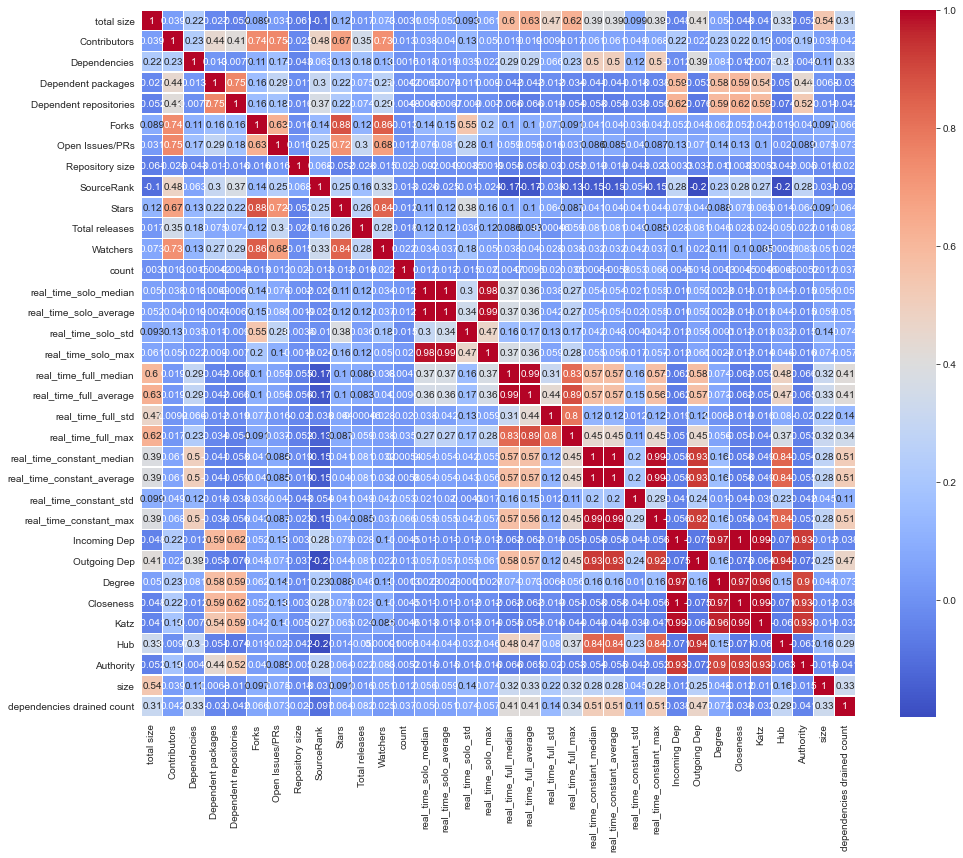

In [198]:
plt.figure(figsize=(16,13))
heatmap_df = q_df
#heatmap_df["real avg"] = heatmap_df["real avg"].astype(float)
cor = heatmap_df.corr()
sns.heatmap(cor, annot=True, cmap="coolwarm", linewidths=.5)

<a name='nsize'></a>
## 11. Negative size values


<br>

In [199]:
q_df["size"][q_df['size'] < 0] = 0

<a name='choose'></a>
## 12. Choosing columns


<br>

In [200]:
q_df.columns

Index(['library', 'dependencies', 'total size', 'size_full', 'Contributors',
       'Dependencies', 'Dependent packages', 'Dependent repositories',
       'First release', 'Forks', 'Latest release', 'Open Issues/PRs',
       'Repository size', 'SourceRank', 'Stars', 'Total releases',
       'Version Number', 'Version Time', 'Watchers', 'count',
       'real_time_solo_median', 'real_time_solo_average', 'real_time_solo_std',
       'real_time_solo_max', 'real_time_full_median', 'real_time_full_average',
       'real_time_full_std', 'real_time_full_max', 'real_time_constant_median',
       'real_time_constant_average', 'real_time_constant_std',
       'real_time_constant_max', 'dependencies full', 'Incoming Dep',
       'Outgoing Dep', 'Degree', 'Closeness', 'Katz', 'Hub', 'Authority',
       'size', 'dependencies drained', 'dependencies drained count'],
      dtype='object')

In [201]:
drop_columns = ['Dependencies', 'Dependent packages', 'Dependent repositories', 'First release', 'Latest release',
               'Repository size', 'Closeness', 'Katz', 'Hub']

q_df = q_df.drop(drop_columns, axis=1)
q_df

,library,dependencies,total size,size_full,Contributors,Forks,Open Issues/PRs,SourceRank,Stars,Total releases,...,real_time_constant_std,real_time_constant_max,dependencies full,Incoming Dep,Outgoing Dep,Degree,Authority,size,dependencies drained,dependencies drained count
0,cutecharts,[jinja2],1.296,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,2.0,56.0,2.0,11.0,503.0,3.0,...,NaN,0.757,"[markupsafe, jinja2]",0,2,0.000431,0.000000,1.880000e-01,[],0
1,postgres,"[psycopg2-binary, psycopg2-pool]",0.144,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,6.0,17.0,16.0,12.0,55.0,12.0,...,NaN,0.760,"[psycopg2-pool, psycopg2-binary]",0,2,0.000431,0.000000,1.440000e-01,[],0
2,gpustat,"[six, nvidia-ml-py3, psutil, blessings]",1.864,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,10.0,202.0,23.0,16.0,2479.0,11.0,...,NaN,0.743,"[psutil, blessings, six, nvidia-ml-py3]",1,4,0.001078,0.000017,8.800000e-02,[],0
3,df2gspread,"[argparse, google-api-python-client, gspread, ...",82.632,47M /home/ubuntu/ve/randomenv/lib/python3.6/si...,6.0,26.0,12.0,10.0,117.0,21.0,...,NaN,1.105,"[idna, google-api-core, certifi, google-api-py...",0,31,0.006684,0.000000,0.000000e+00,[],0
4,ddeint,"[numpy, scipy]",87.040,62M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,NaN,NaN,4.0,NaN,4.0,...,NaN,0.790,"[scipy, numpy]",0,2,0.000431,0.000000,4.000000e-02,[],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4570,hep-ml,"[theano, numpy, pandas, six, scipy, scikit-learn]",157.900,62M /home/ubuntu/ve/randomenv/lib/python3.6/si...,8.0,48.0,NaN,11.0,131.0,7.0,...,0.046792,0.906,"[pytz, pandas, six, python-dateutil, threadpoo...",0,10,0.002156,0.000000,7.105427e-15,[],0
4571,pyats.aetest,"[pyats.results, pyats.aereport, jinja2, pyats....",66.252,39M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,NaN,NaN,5.0,NaN,40.0,...,0.030446,1.099,"[idna, dill, multidict, pycparser, psutil, asy...",7,37,0.009487,0.000074,3.951200e+01,"[async-lru, unicon.plugins, yamllint, pyats.co...",13
4572,dicrivers,[],0.040,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,1.0,0.0,NaN,5.0,1.0,1.0,...,0.043177,0.784,[],0,0,0.000000,0.000000,4.000000e-02,[],0
4573,airr,"[pandas, pyyaml, yamlordereddictloader, setupt...",75.040,47M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,NaN,NaN,9.0,NaN,5.0,...,0.032936,0.846,"[yamlordereddictloader, pyyaml, setuptools, py...",0,8,0.001725,0.000000,2.400000e-01,[],0


In [202]:
pack_q = q_df.to_json()
with open("q_df.txt",'w') as f:
    json.dump(pack_q, f)